In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/english-to-french/fra.txt


In [3]:
import torch

In [4]:
with open('/kaggle/input/english-to-french/fra.txt',"r",encoding='utf-8') as f:
    txt = f.read()

In [5]:
def _preprocess(text):
    out = ''
    for i,char in enumerate(txt):
        if char in ',.!?' and txt[i-1] != ' ':
            out += ' ' + char
        else:
            out += char
    return out

In [6]:
txt = txt.replace('\u202f',' ').replace('\xa0',' ')

In [7]:
txt = _preprocess(txt)

In [8]:
txt[:100]

'Go .\tVa !\tCC-BY 2 .0 (France) Attribution: tatoeba .org #2877272 (CM) & #1158250 (Wittydev)\nGo .\tMar'

In [11]:
# [row for row in text.split('\n')]

In [12]:
src = []
tgt = []
for i,row in enumerate(txt.split('\n')):
    split_ = row.split('\t')
    if len(split_) > 1:
        src.append(split_[0].split(' ') + ['<eos>'])
        tgt.append(split_[1].split(' ') + ['<eos>'])    

In [13]:
# src[-10:],tgt[-10:]

In [14]:
src_len = [len(src_) for src_ in src]
tgt_len = [len(tgt_) for tgt_ in tgt]

In [15]:
import matplotlib.pyplot as plt

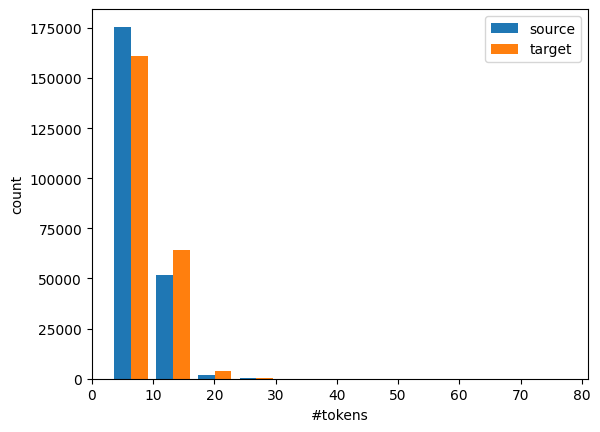

In [16]:
plt.hist([src_len,tgt_len],bins = 11)
plt.xlabel('#tokens')
plt.ylabel('count')
plt.legend(['source','target'])
plt.show()

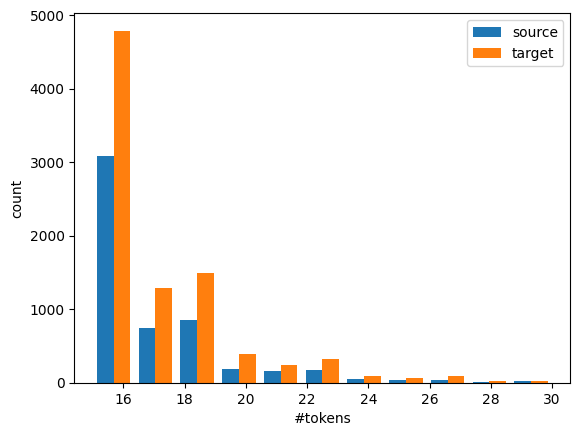

In [17]:
plt.hist([src_len,tgt_len],bins = 11,range = (15,30))
plt.xlabel('#tokens')
plt.ylabel('count')
plt.legend(['source','target'])
plt.show()

In [18]:
import re
import collections

In [19]:
class Vocab:
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        #count token frequencies
        if tokens and isinstance(tokens[0],list):
            tokens = [token for line in tokens for token in line]
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x:x[1], reverse=True)
        
        #list of unique tokens
        self.itos = list(sorted(set(['<unk>'] + reserved_tokens + [token for token, freq in self.token_freqs if freq >= min_freq])))
        self.stoi = {token: idx for idx,token in enumerate(self.itos) }
        
    def __len__(self):
        #length of vocabulary
        return len(self.itos)
    
    def __getitem__(self, tokens):
        #make tokens into indices
        if not isinstance(tokens,(list,tuple)):
            return self.stoi.get(tokens,self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self,indices):
        #make indixes into tokens
        if hasattr(indices,'__len__') and len(indices)>1:
            return [self.itos[int(index)] for index in indices]
        return slef.itos[indices]
    
    @property
    def unk(self):
        return self.stoi['<unk>']

In [20]:
def _build_array(sentences, vocab=None, is_tgt=False, max_len = 100):
    pad_or_trim = lambda seq,max_len:(
    seq[:max_len] if len(seq) > max_len else seq + ['<pad>']*(max_len-len(seq)))
    sentences = [pad_or_trim(s,max_len) for s in sentences]
    if is_tgt:
        sentences = [['<bos>'] + s for s in sentences]
    if vocab is None:
        vocab = Vocab(sentences, min_freq=2)
    array = torch.tensor([vocab[s] for s in sentences])
    valid_len = (array != vocab['<pad>']).type(torch.float32).sum(1)
    return array, vocab, valid_len
# def build_arrays(raw_text, src_vocab=None, tgt_vocan=None):
#     src, tgt = _tokenize(_preprocess(raw_text))#add num_train,num_val

In [21]:
src_arr, src_vocab,valid_len = _build_array(src,max_len=9)

In [22]:
# valid_len

In [23]:
from torch.utils.data import Dataset,DataLoader
from torch import nn

In [56]:
class MTFraEng(nn.Module):
    def __init__(self, num_steps=9, num_train=512, num_val=128, train=True):
        super().__init__()
        
        self.num_steps = num_steps
        self.num_train = num_train
        self.num_val = num_val
        self.train = train
        #array and vocabs:
        self.arrays, self.src_vocab,self.target_vocab = self._build_arrays(self._load())
        
    def _load(self,path='/kaggle/input/english-to-french/fra.txt'):
        with open(path,"r",encoding='utf-8') as f:
            return f.read()
        
    def _preprocess(self, txt):
        txt = txt.replace('\u202f', ' ').replace('\xa0', ' ')
        out = ''
        for i,char in enumerate(txt):
            if char in ',.!?' and txt[i-1] != ' ':
                out += ' ' + char
            else:
                out += char
        return out
    
    def _tokenize(self, txt, max_examples=None):
        src,tgt = [],[]
        for i,row in enumerate(txt.split('\n')):
            if max_examples and i > max_examples:break
            split_ = row.split('\t')
            if len(split_) > 1:
                src.append(split_[0].split(' ') + ['<eos>'])
                tgt.append(split_[1].split(' ') + ['<eos>'])    
        return src,tgt
    
    def _build_array(self, sentences, vocab=None, is_tgt=False):
        pad_or_trim = lambda seq,max_len:(
        seq[:max_len] if len(seq) >= max_len else seq + ['<pad>']*(max_len-len(seq)))
        sentences = [pad_or_trim(s,self.num_steps) for s in sentences]
        if is_tgt:
            sentences = [['<bos>'] + s for s in sentences]
        if vocab is None:
            vocab = Vocab(sentences, min_freq=2)
        array = torch.tensor([vocab[s] for s in sentences])
        valid_len = (array != vocab['<pad>']).type(torch.float32).sum(1)
        return array, vocab, valid_len
    
    def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
        src,tgt = self._tokenize(self._preprocess(raw_text),self.num_train + self.num_val)
#         print(src[:10],tgt[:10])
#         if self.train:
#             src,tgt = src[:self.num_train],tgt[:self.num_train]
#         else:
#             src,tgt = src[self.num_train:self.num_train + self.num_val],tgt[self.num_train:self.num_train + self.num_val]
        src_array, src_vocab, src_valid_len = self._build_array(src, src_vocab)
        tgt_array, tgt_vocab, _ = self._build_array(tgt, tgt_vocab)
        if self.train:
            return ((src_array[:self.num_train], tgt_array[:,:-1][:self.num_train], src_valid_len[:self.num_train], tgt_array[:,1:][:self.num_train]),
                   src_vocab,tgt_vocab)
        else:
            return ((src_array[self.num_train:self.num_train + self.num_val], tgt_array[:,:-1][self.num_train:self.num_train + self.num_val], \
                     src_valid_len[self.num_train:self.num_train + self.num_val], tgt_array[:,1:][self.num_train:self.num_train + self.num_val]),
                   src_vocab,tgt_vocab)
    def __getitem__(self,index):
        return self.arrays[0][index],self.arrays[1][index],self.arrays[2][index],self.arrays[3][index]
    
    def __len__(self):
        return self.arrays[0].shape[0]

In [57]:
data = MTFraEng()

In [58]:
data.arrays[0][:10]

tensor([[31,  2,  3,  4,  4,  4,  4,  4,  4],
        [31,  2,  3,  4,  4,  4,  4,  4,  4],
        [31,  2,  3,  4,  4,  4,  4,  4,  4],
        [31,  2,  3,  4,  4,  4,  4,  4,  4],
        [41,  2,  3,  4,  4,  4,  4,  4,  4],
        [41,  2,  3,  4,  4,  4,  4,  4,  4],
        [69,  0,  3,  4,  4,  4,  4,  4,  4],
        [69,  0,  3,  4,  4,  4,  4,  4,  4],
        [69,  0,  3,  4,  4,  4,  4,  4,  4],
        [69,  0,  3,  4,  4,  4,  4,  4,  4]])

In [59]:
# for i in data[0]:
#     print(i)

In [60]:
train_dataloader = DataLoader(MTFraEng(train=True), batch_size=3)
val_dataloader = DataLoader(MTFraEng(train=False), batch_size=3)

In [61]:
next(iter(train_dataloader))

[tensor([[31,  2,  3,  4,  4,  4,  4,  4,  4],
         [31,  2,  3,  4,  4,  4,  4,  4,  4],
         [31,  2,  3,  4,  4,  4,  4,  4,  4]]),
 tensor([[ 98,   0,   3,   4,   4,   4,   4,   4],
         [  5,   2,   3,   4,   4,   4,   4,   4],
         [ 42, 172,   0,   3,   4,   4,   4,   4]]),
 tensor([3., 3., 3.]),
 tensor([[  0,   3,   4,   4,   4,   4,   4,   4],
         [  2,   3,   4,   4,   4,   4,   4,   4],
         [172,   0,   3,   4,   4,   4,   4,   4]])]

encoder decoder architecture require:\
- the input sequences either truncated to max_length(to process everything in batches) or padded to cover the missing.\
- the decoder input is the first num_steps - 1 charachters and output is [1:] cahraters
- ['UNK'] token in case of unseen/less freq(decided by min_freq) tokens